# Chelyabinsk Test Case

In [1]:
# assuming that you're running this from the examples/ directory
# we need to add the path to the root folder into the system path so that we detect the fragmodel module
import sys
sys.path.append('../')
import numpy as np
from fragmodel.fragmentation_model import FragmentationModel
from fragmodel.planet import Planet
import matplotlib.pyplot as plt

## Setting the initial parameters
We need to first begin by setting the properties of the main body. Specifically these include:

- the mass

- entry velocity

- entry angle

- initial height

- ablation coeffient ($C_h$ or $\sigma_f$)

- initial strength ($\sigma$)

- strength power law coefficient (Weibull-relation $\alpha$)

- fragmentation efficiency ($C_{\text fr}$, see Sankar++2022)

- bulk density ($\rho_d$)

We also need to define the planetary properties and set the density profile ($\rho(z)$) for the atmosphere.

In [2]:
planet = Planet("Earth")
# planet.define_planet(EARTH)
planet.define_temperature_profile('earthtp/chelyabinsk_50k.tp')

In [13]:
''' initial parameters for the main body '''
M      = 1.185e7
v      = 19040.
theta  = 17.
h0     = 45000.
Ch     = 0.12 / (2.e7)
sigma  = 0.3e6
alpha  = 0.18
Cfr    = 1.5
rho_d  = 3300.

''' initialize the model '''
fragmodel = FragmentationModel(M, v, theta, h0, sigma, Ch, rho_d, Cfr, alpha, planet)

[INFO]: fragmodel.fragmentation_model -  Initializing with diameter: 18.999197735415848
[INFO]: fragmodel.fragmentation_model -  planet: Earth g: 9.81 m/s^2; Rp: 6371.0 km


## Adding the child fragments
Once the main body is initialized, we can start adding the child fragments. These are defined by:

- mass

- ram pressure (or dynamic pressure) at which the fragment is released

- [optional] fragmentation efficiency ($C_{\text fr}$)

- [optional] initial strength ($\sigma$)

- [optional] new Weibull strength scaling power ($\alpha$)

In [14]:
fragmodel.add_fragment(0.025*M, 0.975e6, fragment_strength=10.5e6)

## Running the model
Once the fragments are initialized, we can run the model forward in time. We also need to define the timestep and the stopping condition for each fragment (low velocity limit, low height limit). The output is a pandas `DataFrame` object with the state variables for each fragment (in the format `[fragment_id].[key]`, where `[fragment_id]` is either `main` or `f[number]` where number starts from 1 onwards), with one row per timestep. The `[key]` correspond to the following variables:

- mass

- velocity

- angle with respect to the horizontal

- height

- strength

- radius

- surface area

- mass_loss_rate

- acceleration

- dynamic_pressure

- fragment_mass

- fragment_count

- radiated (power)

- deposited (power)

- total (power)

For times before fragments have been released all of these values will be `NaN`s

In [15]:
df = fragmodel.integrate(dt=1e-2, max_time=45, min_velocity=100, min_height=100)

[INFO]: fragmodel.fragment -  Releasing fragment 0 at time 0.00 s and height 45.00 km with mass 11850.00 tonnes and velocity 19040.00 m/s
[INFO]: fragmodel.fragment -  Releasing fragment 1 at time 0.59 s and height 41.66 km with mass 296.25 tonnes and velocity 19035.65 m/s


## Analyzing model results
Let's extract the energy deposition and ablative mass loss and plot those out

In [16]:
# get the observed energy deposition profile
energydepdata = np.loadtxt('energydep/ChelyabinskEnergyDep_Wheeler-et-al-2018.txt', skiprows=1)

### Energy deposition

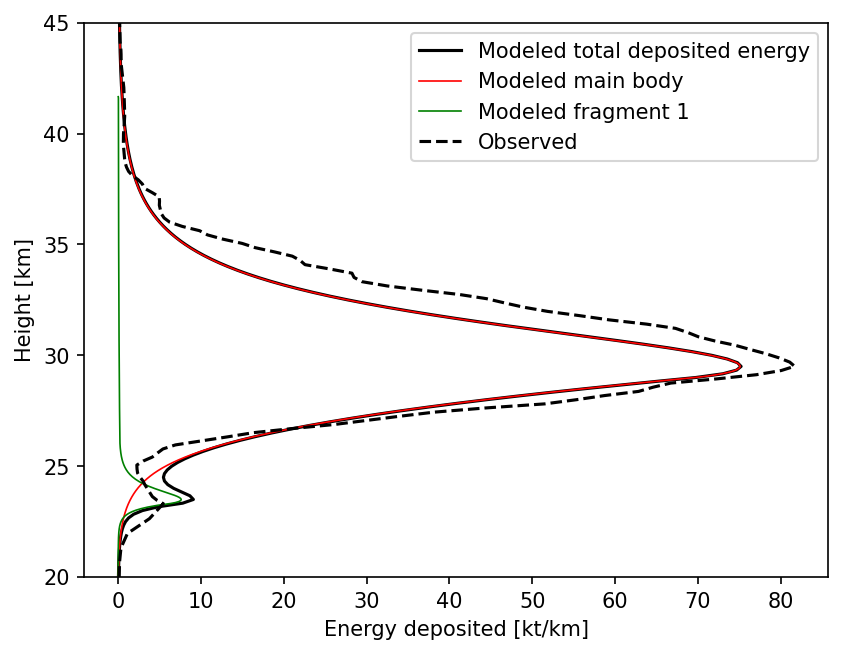

In [17]:
fig, ax = plt.subplots(1, 1, dpi=150)

# 1 kt in joules
kt = 4.184e12

# we need to interpolate the energy deposition curves from the different fragments
# onto the same height grid because they are traveling at different velocities
height = np.linspace(20, 45, 151) * 1e3
# flip the order since np.interp expects sorted x values
f1_deposited = np.interp(height, df['f1.height'][::-1], df['f1.deposited'][::-1]  * (1000 / kt))
main_deposited = np.interp(height, df['main.height'][::-1], df['main.deposited'][::-1]  * (1000 / kt))
ax.plot((main_deposited + f1_deposited), height / 1e3, 'k-', label='Modeled total deposited energy')

# plot the individual energy deposition curves
ax.plot(df['main.deposited'] * (1000 / kt), df['main.height']/1000., 'r-', label='Modeled main body', linewidth=0.8)
ax.plot(df['f1.deposited'] * (1000 / kt), df['f1.height']/1000., 'g-', label='Modeled fragment 1', linewidth=0.8)

# plot the observed data
ax.plot(energydepdata[:,1], energydepdata[:,0], 'k--', label='Observed')
ax.set_ylim((20., 45.))
ax.set_xlabel(r'Energy deposited [kt/km]')
ax.set_ylabel(r'Height [km]')
ax.legend(loc='upper right')

### Ablative mass loss fraction
To calculate the mass lost by ablation, we need to first remove the mass lost due to fragmentation from the main body, and then calculate the fraction of mass remaining over time

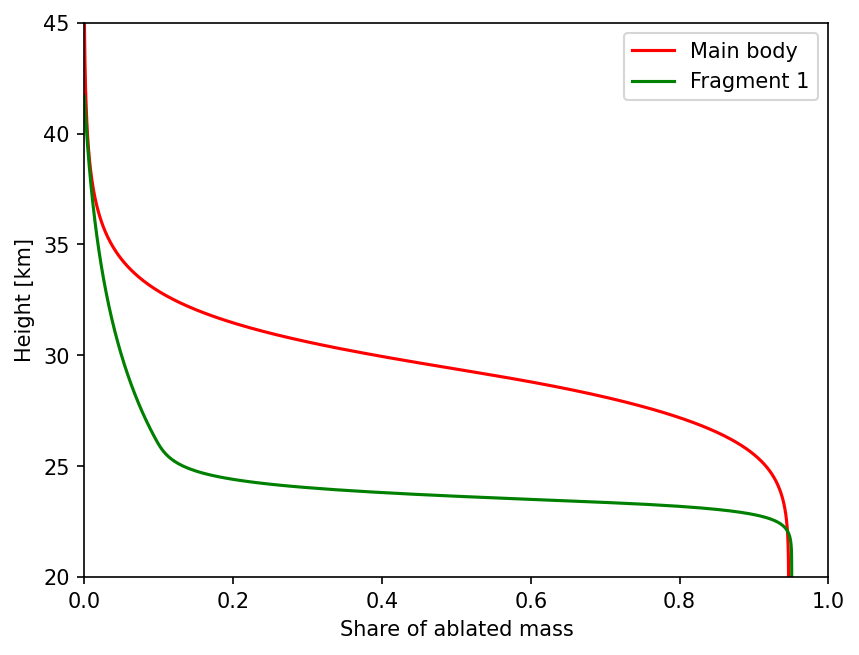

In [19]:
''' second plot is the fraction of mass that is ablated '''
fig, ax = plt.subplots(1, 1, dpi=150)

## construct the ablated mass profile
mfrag1 = np.array(df['f1.mass'])
mfrag1[np.isfinite(mfrag1)] = fragmodel.fragments[0].initial_mass
mfrag1[np.isnan(mfrag1)] = 0
mmain = fragmodel.main_body.initial_mass - mfrag1
mainablation = 1. - df['main.mass'] / mmain

ax.plot(mainablation, df['main.height'] / 1e3, 'r-', label='Main body')
ax.plot(1 - df['f1.mass'] / fragmodel.fragments[0].initial_mass, df['f1.height'] / 1e3, 'g-', label='Fragment 1')

ax.set_ylim((20., 45.))
ax.set_xlim((0., 1.))
ax.set_xlabel(r'Share of ablated mass')
ax.set_ylabel(r'Height [km]')
ax.legend(loc='upper right')

plt.show()